1. 네이버 영화리뷰 데이터셋(NSMC, Naver Sentiment Movie Corpus) 분류

In [ ]:
"""
** 데이터셋 크기/특성에 맞는 모델 전략 세우는 게 중요 **

데이터셋 특징
- 텍스트 길이 짧음 / 노이즈 많음 / 이진 분류(긍정 or 부정)

모델 선정
- 단어 빈도 기반 통계적 모델 TF-IDF (순서+문맥 반영 RNN은 과하다)

전처리 & 피처화
- 특수문자/기호/한글 외 제거(이모티콘, 기호 등) + 불용어("ㅋㅋ", "ㅠㅠ")도 제거
- TfidfVectorizer로 TF-IDF 준비

모델링 : LogisticRegression vs MultinomialNB
- LogisticRegression : 경계를 수학적으로 정밀하게 그어 판별(선형).
                       텍스트 분류에서 성능 good
- MultinomialNB : 피처(단어)들이 서로 조건부 독립이라고 가정 + 베이즈 정리 기반 확률 분류.
                  텍스트에서 baseline으로 자주 사용 (단어 독립 가정이 잘 맞음, 계산 빠름)

모델 개선
- 파이프라인 : 전처리(TfidfVectorizer) + 모델(LegReg vs NB) 묶기
- 튜닝 : GridSearchCV로 하이퍼파라미터 탐색
        -> ngram_range : 연속된 단어 묶음으로 봐서 의미 구분 명확히
        -> min_df : 너무 희귀한 단어는 노이즈로 보고 제거
        -> C : 로지스틱회귀 규제 강도 제어 (역수, 학습데이터에 대한 집착도)
=> 튜닝으로 실제 제출 가능한 수준의 성능, 88% 이상을 뽑기

결과 분석 & 보고
- Confusion Matrix : 어떤 라벨에서 틀리는가
- Classification Report : Precision/Recall 밸런스 (얼마나 놓치는지, 잡은 건 다 맞췄는지)
- 오분류 파악 : 감정 섞인 리뷰에서 왜 틀렸는지 파악
=> 모델이 어떤 상황에 약한지 파악 후 개선 방향 잡기

산출물
- 최종 모델 저장 : joblib(파이썬 객체 직렬화 - dump/load)
"""

import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import (
  train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
  accuracy_score, precision_recall_fscore_support, classification_report,
  confusion_matrix, roc_auc_score, roc_curve
)
import joblib
import warnings

warnings.filterwarnings("ignore") # 실습 중 경고 
plt.rcParams["figure.dpi"] = 120 # 해상도 설정

In [ ]:
# 경로 세팅
ROOT = Path.cwd()
DATA_ROOT = ROOT / "data"
ART_ROOT  = ROOT / "artifacts"

DATASET = "nsmc"
ART_SUB = "01_text"

DS_DIR  = DATA_ROOT / DATASET
ART_DIR = ART_ROOT #/ ART_SUB
for d in [DS_DIR, ART_DIR]: d.mkdir(parents=True, exist_ok=True)

print("[경로 설정] DS_DIR :", DS_DIR.resolve())
print("[경로 설정] ART_DIR:", ART_DIR.resolve())

# 파일 존재 체크
TRAIN_PATH = DS_DIR / "ratings_train.txt"
TEST_PATH = DS_DIR / "ratings_test.txt"

assert TRAIN_PATH.exists() and TEST_PATH.exists(), "[파일 없음] ratings_train/test.txt 필요"

[경로 설정] DS_DIR : C:\Users\dkjjk\ai-ml\mini_projects\data\nsmc
[경로 설정] ART_DIR: C:\Users\dkjjk\ai-ml\mini_projects\artifacts\01_text


In [4]:
# 파일이 없을 경우 (다운로드)
if not TRAIN_PATH.exists() or not TEST_PATH.exists():
  import ssl, urllib.request; ssl._create_default_https_context = ssl._create_unverified_context
  # 일부 환경에서의 SSL 인증 이슈 대비
  TRAIN_URL = "https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt"
  TEST_URL  = "https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt"
  DS_DIR.mkdir(parents=True, exist_ok=True)
  if not TRAIN_PATH.exists(): urllib.request.urlretrieve(TRAIN_URL, TRAIN_PATH)
  if not TEST_PATH.exists(): urllib.request.urlretrieve(TEST_URL, TEST_PATH)

In [5]:
# 데이터 로드
train = pd.read_csv(TRAIN_PATH, sep='\t')
test = pd.read_csv(TEST_PATH, sep='\t')

# 기본 검증 : 데이터셋의 특성이 알고 있는 것과 맞는지
assert {"id", "document", "label"}.issubset(train.columns), "train 컬럼 불일치"
assert {"id", "document", "label"}.issubset(test.columns), "test 컬럼 불일치"
assert train["label"].dropna().isin([0,1]).all(), "train 라벨 값 이상"
assert test["label"].dropna().isin([0,1]).all(), "test 라벨 값 이상"

# 결측값(NaN) : 모델 학습에 필수적인 document, label 컬럼 확인
train = train.dropna(subset=["document", "label"]) # 결측치 있는 "행을 제거"
test = test.dropna(subset=["document", "label"])
# 공백만 있는 빈 문장 제거 : document 컬럼을 문자열로 변환, 앞뒤 공백을 제거했는데도 빈 값(False)이면 제거(빈 값이 아닌 값만 인덱싱)
train = train[train["document"].astype(str).str.strip().astype(bool)]
test = test[test["document"].astype(str).str.strip().astype(bool)]

print("train shape:", train.shape, "/ test shape:", test.shape)
print("train label dist:\n", train["label"].value_counts(normalize=True).round(3)) # normalize=True : 카운트 -> 비율
print("test label dist\n", test["label"].value_counts(normalize=True).round(3))

train shape: (149995, 3) / test shape: (49997, 3)
train label dist:
 label
0    0.501
1    0.499
Name: proportion, dtype: float64
test label dist
 label
1    0.503
0    0.497
Name: proportion, dtype: float64


count    149995.000000
mean         32.489270
std          28.414373
min           0.000000
25%          14.000000
50%          24.000000
75%          40.000000
max         140.000000
Name: text, dtype: float64

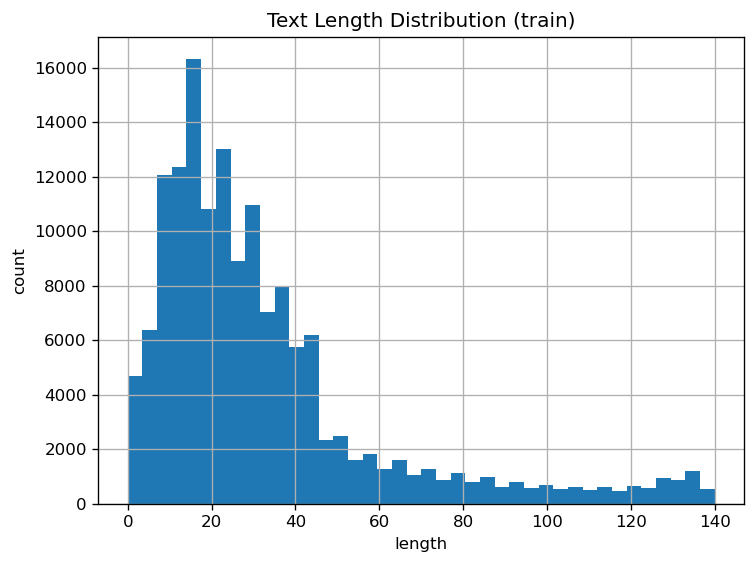

,text,label
95090,이무영 뭐하는 인간인가,0
67579,일본특유의 서정적임과 순수한 영상이 돋보이네요,1
149421,블레이드 1원 수작이었는데 암울한 분위기 하며 캐릭터성은 말할것도 없고 2편은 좀 ...,0
72480,명언 평점은 거짓말을 하지않는다 고로 평점은 진실만을 말한다,0
21232,내생애 최악의 영화였다,0


In [6]:
# [전처리] 텍스트 클렌징 (최소)
# 한국어 NSMC 기준, 과한 정규화는 성능↓ -> 최소로: "한/영/숫자"만 남김
def clean_min(s:str) -> str:
  s = str(s).lower()
  s = re.sub(r"http\S+|www\.\S+", " ", s) # URL 제거
  s = re.sub(r"[^0-9a-zA-Z가-힣\s]", " ", s) # 한/영/숫자 외 제거
  s = re.sub(r"\s+", " ", s).strip() # 연속 공백 -> 하나의 공백으로, 문자열 맨 앞/뒤 공백도 제거
  return s

train["text"] = train["document"].astype(str).apply(clean_min)
test["text"] = test["document"].astype(str).apply(clean_min)

# train_full_set, test_official의 라벨 0/1 -> neg/pos 변환 : 0은 neg이고 1은 pos라는 사람 기억도 필요 없도록
y_train_full = train["label"].map({0:"neg", 1:"pos"}).astype(str) # 놓친 NaN(float) 있을까봐 타입 통일
y_test_off = test["label"].map({0:"neg", 1:"pos"}).astype(str)

lengths = train["text"].str.len() # 리뷰별 글자 수
display(lengths.describe())

plt.figure(); lengths.hist(bins=40)
plt.title("Text Length Distribution (train)")
plt.xlabel("length"); plt.ylabel("count")
plt.tight_layout(); plt.show()

display(train.sample(5)[["text", "label"]])

In [9]:
# 학습/검증 분할
X_train_full = train["text"]
X_train, X_valid, y_train, y_valid = train_test_split(
  X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42
)
print("train:", X_train.shape, "valid:", X_valid.shape, "/ official test:", test.shape)
print(test["text"].shape)

train: (119996,) valid: (29999,) / official test: (49997, 4)
(49997,)


In [11]:
# [모델학습] 베이스라인 비교 : (TF-IDF based) Logistic vs MultinomialNB
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipe_lr = Pipeline([
  ("tfidf", TfidfVectorizer(max_features=30000)), # 가장 중요한 단어 상위 N개만 사용 (특징/차원/단어 수 제한 => 메모리, 계산속도, 희소행렬 크기 조절)
  ("clf", LogisticRegression(max_iter=500))
])
pipe_nb = Pipeline([
  ("tfidf", TfidfVectorizer(max_features=30000)),
  ("clf", MultinomialNB())
])

lr_cv = cross_val_score(pipe_lr, X_train, y_train, cv=skf, scoring="f1_weighted", n_jobs=-1)
nb_cv = cross_val_score(pipe_nb, X_train, y_train, cv=skf, scoring="f1_weighted", n_jobs=-1)
# F1-score : Precision/Recall 조화 평균
# weighted -> 클래스의 데이터 수(support)를 가중치로 곱함
# (데이터 많은 클래스의 영향 ↑ => 불균형한 라벨 분포에 맞춰 성능을 더 현실적으로 반영)

print(f"[Baseline] Logistic F1(w): {lr_cv.mean():.4f} ± {lr_cv.std():4f}")
print(f"[Baseline] MultinomialNB F1(w): {nb_cv.mean():.4f} ± {nb_cv.std():.4f}")
"""
F1(w) : Precision/Recall 균형을 반영한 모델 정확도
- 평균 : 모델의 성능 (클수록 좋음)
- 분산 : 모델 성능의 일관성 (fold별 결과 차이, 작을수록 좋음)

** precision : 모델이 잡은 것 중 맞춘 것
** recall : 전체 중 모델이 잡았고 맞춘 것 (모델이 놓친 것 포함)
-> 모델이 한 클래스만 잘 맞추는 상황을 파악 가능
=> 클래스 불균형일때, 즉 소수 클래스도 제대로 잡아내야 하는 상황에서 F1 사용
   (Accuracy는 클래스가 대체로 균형적일때, 전체의 대략적인 성능 파악)
"""

[Baseline] Logistic F1(w): 0.8053 ± 0.001896
[Baseline] MultinomialNB F1(w): 0.8132 ± 0.0016


'\nF1(w) : Precision/Recall 균형을 반영한 모델 정확도\n- 평균 : 모델의 성능 (클수록 좋음)\n- 분산 : 모델 성능의 일관성 (fold별 결과 차이, 작을수록 좋음)\n\n** precision : 모델이 잡은 것 중 맞춘 것\n** recall : 전체 중 모델이 잡았고 맞춘 것 (모델이 놓친 것 포함)\n-> 모델이 한 클래스만 잘 맞추는 상황을 파악 가능\n=> 클래스 불균형일때, 즉 소수 클래스도 제대로 잡아내야 하는 상황에서 F1 사용\n   (Accuracy는 클래스가 대체로 균형적일때, 전체의 대략적인 성능 파악)\n'

-> NSMC 데이터셋에서, baseline 성능은 F1 약 81%, 두 모델 다 안정적(편차 작음)<br>
</t>약 0.8%의 근소한 차이로, NB가 더 나은 결과를 보임

In [12]:
# [튜닝] GridSearchCV로 ngram, min_df, max_df, C 최적화
"""
df (document frequency) -- 정수는 카운트, 실수는 비율
- min_df : 단어가 너무 적게 등장하면 무시
           드물게 등장하는 단어는 노이즈로 취급, 제거하여 과적합 방지
- max_df : 단어가 너무 많이 등장하면 무시
           너무 흔한 단어(불용어) 제거하여 정보량 없는 단어 배제

ngram : n개의 단어를 묶어서 사용
- n=1(unigram) : "재미"/"있다"/"없다" 다 따로봐서 모델 혼동
- n=2(bigram) : "재미 있다"/"재미 없다"로 판단 (연속된 단어 조합 정보 반영)
"""

pipe = Pipeline([
  ("tfidf", TfidfVectorizer()), # 튜닝이니까 제한X (어차피 params로 제한됨)
  ("clf", LogisticRegression(max_iter=800)) # default (그리드에서 교체)
])

param_grid = [
  # LogisticRegression params
  {
    "clf": [LogisticRegression(max_iter=800)], # param_grid니까 "파라미터명" : 후보 리스트 형태 맞춤
    "tfidf__ngram_range": [(1,1), (1,2)], # (a,b) : a에서 b까지
                                          # (1,1) unigram / (2,2) bigram / (1,2) unigram+bigram / (1,3) unigram+bigram+trigram
    "tfidf__min_df": [2, 5],
    "tfidf__max_df": [0.9, 0.95],
    "clf__C": [0.5, 1.0, 2.0],
    "clf__penalty": ["l2"], # 로지스틱 회귀에서 가중치가 너무 커지는 걸(과적합) 막기 위한 규제의 종류
  },
  # MultinomialNB params
  {
    "clf": [MultinomialNB()],
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__min_df": [2, 5],
    "tfidf__max_df": [0.9, 0.95],
    "tfidf__use_idf": [True, False], # NB는 보통 카운트가 유리한 경우가 많아서 TF vs TF-IDF 둘 다 시도
                                     # TF는 그냥 카운트, TF-IDF(역문서빈도)는 많이 등장할수록 가중치↓
                                     # NB는 모델 가정("빈도 기반" 확률) 상 TF 그대로가 더 맞음. TF-IDF는 좀 왜곡될수도.
    "tfidf__norm": ["l2", None], # 벡터화 결과를 정규화 : 리뷰별 단어 수를 보정 (Multinomial은 빈도 기반이므로 벡터 크기에 민감 -- ex: "좋다 좋다", "좋다 좋다 좋다")
                                 # "l2" : 유클리드 거리(L2 norm)으로 정규화
    "clf__alpha": [0.5, 1.0, 2.0], # 특정 단어가 어떤 클래스에 한 번도 안나왔을 때 확률 0이 됨
                                   # 곱셈 구조 상 전체 확률 0이 되므로 모든 단어 빈도에 alpha를 더해 방지 (스무딩)
                                   # alpha=1.0 기본(라플라스 스무딩) / alpha < 1.0 스무딩 약하게(데이터 믿기) / alpha > 1.0 스무딩 강하게(희귀 단어 영향 줄임)
  }
]

gs = GridSearchCV(
  pipe,
  param_grid=param_grid,
  cv=skf,
  scoring="f1_weighted",
  n_jobs=-1,
  verbose=1 # 진행 상황 출력 (기본 0: 없음/ 1: fold별 진행률 막대/ 2: 각 parameter 조합+fold별 점수/.. 값 커질수록 로그 상세)
)
gs.fit(X_train, y_train)

best_model = gs.best_estimator_
best_clf_name = best_model.named_steps["clf"].__class__.__name__

print("[GridSearch] Best Estimator:", best_clf_name)
print("[GridSearch] Best Params:", gs.best_params_)
print("[GridSearch] Best CV F1(w):", f"{gs.best_score_:.4f}")

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[GridSearch] Best Estimator: MultinomialNB
[GridSearch] Best Params: {'clf': MultinomialNB(), 'clf__alpha': 1.0, 'tfidf__max_df': 0.9, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__norm': 'l2', 'tfidf__use_idf': True}
[GridSearch] Best CV F1(w): 0.8195


- 공정한 모델 선택 : "baseline이 약간 더 낫다" 보다, 같은 전처리/교차검증 조건에서 최적 튜닝까지 반영해 선택
- LR 최적화 포인트 : C + n-gram/빈도(df) 컷오프
- NB 최적화 포인트 : alpha (부수적으로 IDF/정규화 유무)

In [13]:
# [Valid 평가]
y_pred = best_model.predict(X_valid)

# 성능 평가 : accuracy, precision, recall, f1
acc = accuracy_score(y_valid, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(
  y_valid, y_pred, average="weighted", zero_division=0
)

print(f"Accuracy : {acc:.4f}")
print(f"Precision(w): {prec:.4f} | Recall(w): {rec:.4f} | F1(w): {f1:.4f}")
print(f"\nClassification Report:\n", classification_report(y_valid, y_pred, zero_division=0))

Accuracy : 0.8221
Precision(w): 0.8232 | Recall(w): 0.8221 | F1(w): 0.8219

Classification Report:
               precision    recall  f1-score   support

         neg       0.80      0.85      0.83     15034
         pos       0.84      0.79      0.82     14965

    accuracy                           0.82     29999
   macro avg       0.82      0.82      0.82     29999
weighted avg       0.82      0.82      0.82     29999



- 클래스 분포(neg/pos support)가 거의 균형 => accuray, macro avg, weighted avg 비슷
- neg : precision 0.8 / recall 0.85 : 부정 잘 찾아내지만, 부정이라고 잘못 판단하는 경우가 좀 있다 (pos로 잘못보낸게 약 15%)
- pos : 정밀 0.84 / 재현 0.79 : 긍정 꽤 잘 맞히지만, 놓치는 게 더 많다. (neg로 잘못보낸게 약 21%)

재현율(Recall)을 올려서 더 잘 잡고 싶다면,
- min_df 낮춰서 희귀 토큰 포함
- ngram_range 조정으로 표현력 확장
- alpha를 낮춰 스무딩 약화 : 희귀 단어 영향 증가
- (LogReg라면, 임계값 낮춰서 더 많이 잡기)

정밀도(Precision) 유지/상향이 더 중요하다면,
- min_df 올리고, max_df 낮춰서 노이즈 줄이기
- alpha 올려서 스무딩 강화 : 과한 토큰 신호 완화
- (LogReg라면, 임계값 올려서 헛양성 줄이기)

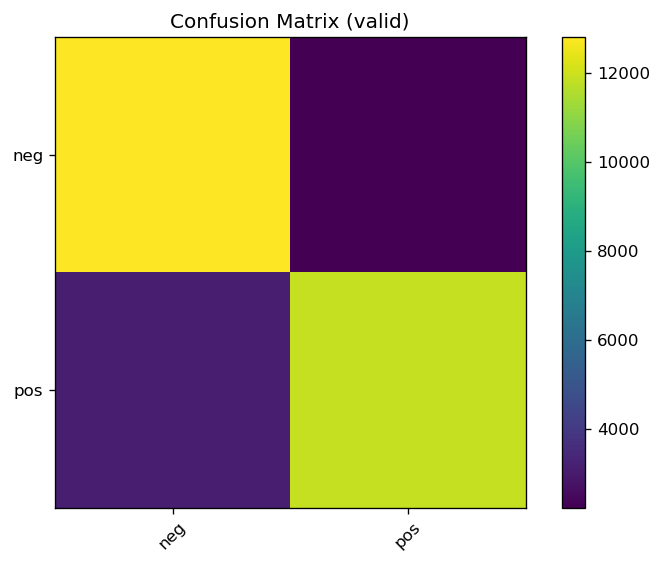

In [14]:
# 혼동행렬
labels_sorted = np.unique(y_valid) # 사전 순 ["neg", "pos"]
cm = confusion_matrix(y_valid, y_pred, labels=labels_sorted)

plt.figure(); plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (valid)")
plt.xticks(range(len(labels_sorted)), labels_sorted, rotation=45) # 눈금
plt.yticks(range(len(labels_sorted)), labels_sorted)
plt.colorbar(); plt.tight_layout(); plt.show()

-> neg는 괜찮은데 pos가 좀... 덜 잡네

-> 재현율이 중요한 경우, 임계값(threshold)를 낮추거나 / class_weight="balanced" / alpha 조정해서 FN 줄이기

** 혼동행렬 필요한 경우
- 불균형 데이터/비용에 민감(FP vs FN 비용 다를때)
- 임계값 튜닝(ROC과 PR보고 결정)
- 오분류 분석

AUC: 0.9149


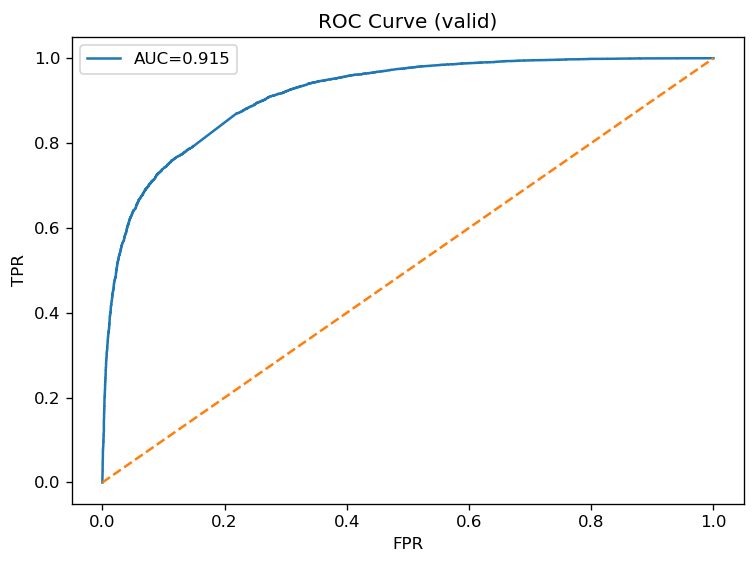

In [15]:
# ROC-AUC (이진분류)
if len(labels_sorted) == 2:
  """
  y_socre : ROC/AUC(threshold)를 위한 "연속형 점수"
  - predict_proba(X): 클래스(y)별 확률 => [neg일 확률, pos일 확률] (둘의 합은 1)
  - decision_function(X): 모델별 원 점수(LogRef에선 로짓, SVM에선 초평면까지의 거리 margin)
                          작을수록 음성(0/neg) <-> 클수록 양성(1/pos)
  """
  if hasattr(best_model, "predict_proba"):
    y_score = best_model.predict_proba(X_valid)[:,1] # pos 확률만 추출
  elif hasattr(best_model, "decision_function"):
    # 지금 사용하는 모델에 predict_proba 없으면 decision_function으로
    y_score = best_model.decision_function(X_valid)
  else:
    y_score = None
  
  if y_score is not None:
    pos_class = sorted(labels_sorted)[1] # 안전하게 정렬 한 번 더
    
    y_true = (y_valid == pos_class).astype(int) # neg/pos -> 0/1 for AUC 계산
    auc = roc_auc_score(y_true, y_score)
    fpr, tpr, _ = roc_curve(y_true, y_score)
    # fpr : 오탐, 잘못 잡음 (neg인데 pos로 잡아버림) <-> tpr : 잘 잡은 (pos를 pos로)
    # fnr : 미탐, 놓침 (pos로 잡아야하는데 neg로 놓침) <-> tnr : 잘 놓침(걸러냄) (neg를 neg로)
    print(f"AUC: {auc:.4f}")

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.plot([0,1], [0,1], linestyle="--")
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.title("ROC Curve (valid)")
    plt.legend(); plt.tight_layout(); plt.show()

MultinomialNB도 predict_proba를 사용하므로,<br>
LogReg처럼 내장 threshold가 아닌 밖에서 내가 임의로 쓰면 됨!
- proba = best_model.predict_proba(X_valid)[:, pos_idx]
- t = 0.42 # 임의의 임계값
- y_pred = np.where(proba >= t, "pos", "neg")

ROC/AUC는 "이진 분류"라는 걸 기억!

In [16]:
# 테스트셋 점검
print(test["document"].isna().sum())                 # NaN 개수
print((test["document"].astype(str).str.strip()=="").sum())  # 공백-only 개수
print(test.columns)

0
0
Index(['id', 'document', 'label', 'text'], dtype='object')


In [17]:
# [Official Test 평가]
X_test_off = test["text"] # cleaned
y_test_off = y_test_off # neg/pos

y_pred_off = best_model.predict(X_test_off)
acc_off = accuracy_score(y_test_off, y_pred_off)
prec_off, rec_off, f1_off, _ = precision_recall_fscore_support(
  y_test_off, y_pred_off, average="weighted", zero_division=0
)

print(f"[Official Test]\nAcc: {acc_off:.4f} | F1(w): {f1_off:.4f}")

[Official Test]
Acc: 0.8222 | F1(w): 0.8221


In [18]:
# 샘플 추론
samples = [
  "스토리는 평범했지만 배우 연기가 정말 좋았다.",
  "최악... 시간 낭비였다.",
  "생각보다 꽤 재밌고 감동적이었음!",
  "그저 그럼",
  "취향 엄청 탈 듯"
]
for s, p in zip(samples, best_model.predict(samples)):
  print(f"'{s}' -> {p}")

'스토리는 평범했지만 배우 연기가 정말 좋았다.' -> pos
'최악... 시간 낭비였다.' -> neg
'생각보다 꽤 재밌고 감동적이었음!' -> pos
'그저 그럼' -> neg
'취향 엄청 탈 듯' -> neg


In [36]:
# 모델 저장
MODEL_PATH = ART_DIR / "nsmc_tfidf.joblib"
joblib.dump(best_model, MODEL_PATH)
print(f"\n[저장 완료] {MODEL_PATH.resolve()}")


[저장 완료] C:\Users\dkjjk\ai-ml\mini_projects\artifacts\01_text\nsmc_tfidf.joblib
